# Setup

In [1]:
# !git clone https://github.com/Sopralapanca/medium-skill-based-agents.git
# %cd /content/medium-skill-based-agents
# !ls

In [2]:
!uv --version

uv 0.9.18 (0cee76417 2025-12-16)


In [3]:
# ! yes | pip uninstall gym

In [4]:
# !uv pip install -r pyproject.toml

In [5]:
# !python create_dataset.py

In [6]:
# !python train_vos.py
# !python train_vok.py
# !python train_usr.py

Import the required packages, build the environment and test if it works

c:\Users\giaco\VSCode Projects\medium-articles\skill-based-agents\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


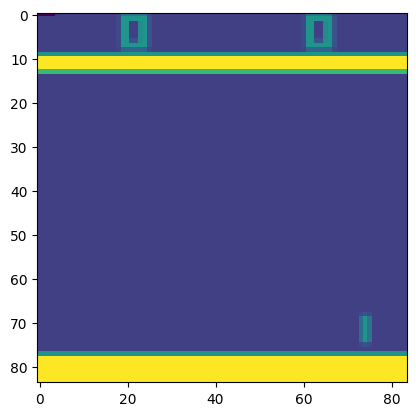

In [7]:
# general imports
import torch
import yaml
import numpy as np
import random
import os

# training imports
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage

import matplotlib.pyplot as plt

import tensorflow as tf

# IMPORTANT - REGISTER THE ENVIRONMENTS
import gymnasium as gym
import ale_py 
gym.register_envs(ale_py)

# Load config
_config_path = "./configs.yaml"

_config = {}
with open(_config_path, "r") as f:
    _config = yaml.safe_load(f) or {}
        

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # ignore tensorflow warnings about CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

seed = None
if seed is not None:    
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


env = _config.get("ENVS", "PongNoFrameskip-v4")[0]
with open(f'environment_configs/{env}.yaml', 'r') as file:
        environment_configuration = yaml.safe_load(file)["config"]


environment_configuration["f_ext_kwargs"]["device"] = device  #do not comment this, it is the parameter passed to the feature extractor
environment_configuration["game"] = env



vec_envs = make_atari_env(env, n_envs=environment_configuration["n_envs"], seed=seed)
vec_envs = VecFrameStack(vec_envs, n_stack=environment_configuration["n_stacks"])
vec_envs = VecTransposeImage(vec_envs)

# execute some steps with random moves
obs = vec_envs.reset()

for i in range(10):
    action = [vec_envs.action_space.sample() for _ in range(environment_configuration["n_envs"])]
    obs, rewards, dones, info = vec_envs.step(action)

# obs[0] has shape (4, 84, 84) because there are 4 stacked environments, take the first
observation = obs[0][-1]
plt.imshow(observation)
plt.show()



In [8]:
from skills.autoencoder import Autoencoder
from skills.unsupervised_state_representation import UnsupervisedStateRepresentationModel
from skills.video_object_keypoints import Transporter
from skills.video_object_segmentation import VideoObjectSegmentationModel
from utils.feature_extractors import WeightSharingAttentionExtractor

# init skills
autoencoder = Autoencoder(channels=1).to(device)

# observation has shape (32, 4, 84, 84), 
# observation = obs[0][0][None, :, :] # (1, 84, 84)

print(obs[0].shape) # (4, 84, 84)


usr = UnsupervisedStateRepresentationModel(observation=obs[0], device=device)
vok = Transporter().to(device)
vos = VideoObjectSegmentationModel(device=device)


skills = [
    usr.get_skill(device=device),
    vok.get_skill(device=device, keynet_or_encoder="encoder"),
    vok.get_skill(device=device, keynet_or_encoder="keynet"),
    vos.get_skill(device=device)
]

# Test each skill's input adapter
print("\nTesting skill input adapters:")
test_obs = obs[:1]  # Take one sample from batch
test_obs = torch.tensor(test_obs, dtype=torch.float32).to(device)

for skill in skills:
    print(f"\nSkill: {skill.name}")
    print(f"Input shape: {test_obs.shape}")
    adapted = skill.input_adapter(test_obs)
    print(f"After adapter: {adapted.shape}")

(4, 84, 84)

Testing skill input adapters:

Skill: state_rep_uns
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 1, 160, 210])

Skill: obj_key_enc
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 1, 84, 84])

Skill: obj_key_key
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 1, 84, 84])

Skill: vid_obj_seg
Input shape: torch.Size([1, 4, 84, 84])
After adapter: torch.Size([1, 2, 84, 84])


In [9]:
from stable_baselines3 import PPO
from rl_zoo3.utils import linear_schedule


f_ext_kwargs = environment_configuration["f_ext_kwargs"]

environment_configuration["f_ext_name"] = "wsharing_attention_ext"
environment_configuration["f_ext_class"] = WeightSharingAttentionExtractor

f_ext_kwargs["skills"] = skills
f_ext_kwargs["features_dim"] = 256


policy_kwargs = dict(
    features_extractor_class=environment_configuration["f_ext_class"],
    features_extractor_kwargs=f_ext_kwargs,
    net_arch={
        "pi": environment_configuration["net_arch_pi"],
        "vf": environment_configuration["net_arch_vf"],
    },
    # activation_fn=th.nn.ReLU,  # use ReLU in case of multiple layers for the policy learning network
)

logdir = "./tensorboard_logs"

model = PPO(
    "CnnPolicy",
    vec_envs,
    learning_rate=linear_schedule(environment_configuration["learning_rate"]),
    n_steps=128,
    n_epochs=4,
    batch_size=environment_configuration["batch_size"],
    clip_range=linear_schedule(environment_configuration["clip_range"]),
    normalize_advantage=environment_configuration["normalize"],
    ent_coef=environment_configuration["ent_coef"],
    vf_coef=environment_configuration["vf_coef"],
    policy_kwargs=policy_kwargs,
    verbose=1,
    device=device,
    tensorboard_log=logdir,
)

c:\Users\giaco\VSCode Projects\medium-articles\skill-based-agents\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cpu device


In [10]:
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold, StopTrainingOnNoModelImprovement


eval_env = make_atari_env(env, n_envs=environment_configuration["n_envs"])
eval_env = VecFrameStack(eval_env, n_stack=environment_configuration["n_stacks"])
eval_env = VecTransposeImage(eval_env)

run_id = "test_run_1_wsa"
eval_logs = f"eval_logs/{env}/{run_id}"
os.makedirs(eval_logs, exist_ok=True)

eval_callback = EvalCallback(
    eval_env,
    n_eval_episodes=100,
    best_model_save_path=f"./agents/{run_id}",
    log_path=eval_logs,
    eval_freq=5000 * environment_configuration["n_envs"],
    verbose=0,
)

callbacks = [eval_callback]

model.learn(10000, callback=callbacks, tb_log_name=run_id)


Logging to ./tensorboard_logs\test_run_1_wsa_2
-----------------------------
| time/              |      |
|    fps             | 60   |
|    iterations      | 1    |
|    time_elapsed    | 16   |
|    total_timesteps | 1024 |
-----------------------------


KeyboardInterrupt: 